In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Mostrar todas las columnas de un dataframe

pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_parquet('/content/play_by_play.parquet')

df.head()

,id_competition,id_edition,id_partido,id_license,id_equipo,id_playbyplaytype,shirt_number,local,period,minute,second,score_local,score_visitor,posX,posY,liga,edicion,jugador,equipo,T3C,T3I,T2C,T2I,TLC,TLI,Reb,asist,steals,TO,tap,faltas,faltas_rec,puntos,type.description,pista,period_seconds_remaining,inicio_accion,fin_accion,duracion_accion,tipo_reseteo_reloj,tiempo_reloj_posesion
0,1,89,104453,20210392,4339,599,0,True,1,10,0,0,0,NaN,NaN,Liga Endesa,2024,Josep Puerto,Valencia Basket,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Cinco Inicial,CASA,600,False,False,0,24,24
1,1,89,104453,20210088,4345,599,0,False,1,10,0,0,0,NaN,NaN,Liga Endesa,2024,Alberto Abalde,Real Madrid,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Cinco Inicial,FUERA,600,False,False,0,24,24
2,1,89,104453,20210501,4345,599,0,False,1,10,0,0,0,NaN,NaN,Liga Endesa,2024,Mario Hezonja,Real Madrid,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Cinco Inicial,FUERA,600,False,False,0,24,24
3,1,89,104453,20209407,4345,599,0,False,1,10,0,0,0,NaN,NaN,Liga Endesa,2024,Edy Tavares,Real Madrid,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Cinco Inicial,FUERA,600,False,False,0,24,24
4,1,89,104453,20211331,4345,599,0,False,1,10,0,0,0,NaN,NaN,Liga Endesa,2024,Facu Campazzo,Real Madrid,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Cinco Inicial,FUERA,600,False,False,0,24,24


In [ ]:
# --- 1. SELECCIÓN Y RENOMBRADO DE COLUMNAS ---
column_mapping = {
  'id_playbyplaytype': 'id_playbyplaytype', 'local': 'local', 'period': 'period', 'minute': 'minute',
  'second': 'second', 'score_local': 'score_local', 'score_visitor': 'score_visitor',
  'posX': 'posX', 'posY': 'posY', 'license.licenseStr15': 'jugador',
  'team.team_actual_short_name': 'equipo',
  'statistics.3pt_success': 'T3C', 'statistics.3pt_tried': 'T3I', 'statistics.2pt_success': 'T2C',
  'statistics.2pt_tried': 'T2I', 'statistics.points': 'puntos',
  'type.description': 'type.description'
  }

# Filtrar solo las columnas que existen en el DataFrame
cols_to_keep = {k: v for k, v in column_mapping.items() if k in df.columns}
df_total = df[list(cols_to_keep.keys())].copy()
df_total.rename(columns=cols_to_keep, inplace=True)

# --- 2. CONVERSIÓN DE TIPOS DE DATOS ---
for col in df_total.columns:
  if col in ['posX', 'posY']:
    df_total[col] = pd.to_numeric(df_total[col], errors='coerce').astype(float)
  elif col not in ['jugador', 'equipo', 'type.description', 'local']:
    df_total[col] = pd.to_numeric(df_total[col], errors='coerce').fillna(0).astype(int)

# --- 3. CREACIÓN DE NUEVAS COLUMNAS ---
df_total['pista'] = np.where(df_total['local'] == True, 'CASA', 'FUERA')

# --- 4. CÁLCULOS DE TIEMPO Y POSESIÓN ---
df_total['period_seconds_remaining'] = df_total['minute'] * 60 + df_total['second']

# --- inicio_accion y fin_accion ---
df_total['inicio_accion'] = False
df_total['fin_accion'] = False
df_total['next_id'] = df_total['id_playbyplaytype'].shift(-1)
df_total['prev_id'] = df_total['id_playbyplaytype'].shift(1)

cond_inicio_simple = df_total['id_playbyplaytype'].isin([104, 93, 106, 94, 100, 121])
cond_inicio_92 = (df_total['id_playbyplaytype'] == 92) & (~df_total['next_id'].isin([96, 92]))
cond_inicio_101 = (df_total['id_playbyplaytype'] == 101) & (df_total['prev_id'] != 102)
cond_inicio_110 = (df_total['id_playbyplaytype'] == 110) & (df_total['prev_id'] == 159)
cond_inicio_159 = (df_total['id_playbyplaytype'] == 159) & (df_total['prev_id'].isin([97, 98]))
df_total.loc[cond_inicio_simple | cond_inicio_92 | cond_inicio_101 | cond_inicio_110 | cond_inicio_159, 'inicio_accion'] = True

cond_fin_simple = df_total['id_playbyplaytype'].isin([93, 106, 94, 100, 116])
cond_fin_92 = (df_total['id_playbyplaytype'] == 92) & (~df_total['next_id'].isin([96, 92]))
cond_fin_97_98_533 = df_total['id_playbyplaytype'].isin([97, 98, 533]) & (df_total['next_id'] != 105)
cond_fin_110 = (df_total['id_playbyplaytype'] == 110) & (df_total['prev_id'] == 159)
df_total.loc[cond_fin_simple | cond_fin_92 | cond_fin_97_98_533 | cond_fin_110, 'fin_accion'] = True

df_total.drop(columns=['next_id', 'prev_id'], inplace=True)

# --- duracion_accion ---
df_total['duracion_accion'] = 0
for period, group in df_total.groupby('period'):
  tiempo_inicio_posesion = group['period_seconds_remaining'].iloc[0]
  for i, row in group.iterrows():
    tiempo_actual = row['period_seconds_remaining']
    duracion = tiempo_inicio_posesion - tiempo_actual
    df_total.loc[i, 'duracion_accion'] = duracion
    if row['inicio_accion']:
      tiempo_inicio_posesion = tiempo_actual
df_total['duracion_accion'] = df_total['duracion_accion'].astype(int)

# --- 5. MODIFICACIÓN DE FILAS ESPECÍFICAS ---
for i in range(2, len(df_total)):
  if df_total.loc[i, 'type.description'] == 'Falta recibida' and df_total.loc[i-2, 'type.description'] == 'Falta en Ataque':
    df_total.loc[i, 'type.description'] = 'Falta recibida ataque'
    df_total.loc[i, 'id_playbyplaytype'] = 999

# --- 6. CÁLCULO DEL RESETEO DEL RELOJ ---
df_total['tipo_reseteo_reloj'] = np.nan
if not df_total.empty:
  df_total.loc[0, 'tipo_reseteo_reloj'] = min(24, df_total.loc[0, 'period_seconds_remaining'])

for i in range(len(df_total)):
  calculated_value = np.nan
  if (i == 0) or (df_total.loc[i, 'inicio_accion'] == True):
    calculated_value = 24

  description = df_total.loc[i, 'type.description']
  if description == "Falta recibida":
    previous_description = df_total.loc[i-1, 'type.description'] if i > 0 else ""
    if previous_description == "Personal no TL":
      duration = df_total.loc[i, 'duracion_accion']
      calculated_value = 14 if duration >= 11 else 24 - duration
    else:
      calculated_value = 24

  if description == "Rebote Ofensivo" and df_total.loc[i, 'inicio_accion']:
    duration_to_check = df_total.loc[i-1, 'duracion_accion'] if i > 0 else df_total.loc[i, 'duracion_accion']
    calculated_value = 14 if duration_to_check >= 11 else 24 - duration_to_check

  if pd.notna(calculated_value) and i + 1 < len(df_total):
    period_seconds_destino = df_total.loc[i+1, 'period_seconds_remaining']
    df_total.loc[i+1, 'tipo_reseteo_reloj'] = min(calculated_value, period_seconds_destino)

df_total['tipo_reseteo_reloj'] = df_total['tipo_reseteo_reloj'].ffill().fillna(0).astype(int)

# --- 8. CÁLCULO DEL TIEMPO EN EL RELOJ DE POSESIÓN ---
df_total['tiempo_reloj_posesion'] = df_total['tipo_reseteo_reloj'] - df_total['duracion_accion']
df_total['tiempo_reloj_posesion'] = df_total['tiempo_reloj_posesion'].clip(lower=0)

In [ ]:
df_total.head()

,id_playbyplaytype,local,period,minute,second,score_local,score_visitor,posX,posY,type.description,pista,period_seconds_remaining,inicio_accion,fin_accion,duracion_accion,tipo_reseteo_reloj,tiempo_reloj_posesion
0,599,True,1,10,0,0,0,NaN,NaN,Cinco Inicial,CASA,600,False,False,0,24,24
1,599,False,1,10,0,0,0,NaN,NaN,Cinco Inicial,FUERA,600,False,False,0,24,24
2,599,False,1,10,0,0,0,NaN,NaN,Cinco Inicial,FUERA,600,False,False,0,24,24
3,599,False,1,10,0,0,0,NaN,NaN,Cinco Inicial,FUERA,600,False,False,0,24,24
4,599,False,1,10,0,0,0,NaN,NaN,Cinco Inicial,FUERA,600,False,False,0,24,24


In [ ]:
df_shots = df_total.drop(columns=['id_playbyplaytype', 'pista', 'inicio_accion', 'fin_accion', 'duracion_accion', 'tipo_reseteo_reloj'])

In [ ]:
df_shots.head()

,local,period,minute,second,score_local,score_visitor,posX,posY,type.description,period_seconds_remaining,tiempo_reloj_posesion
0,True,1,10,0,0,0,NaN,NaN,Cinco Inicial,600,24
1,False,1,10,0,0,0,NaN,NaN,Cinco Inicial,600,24
2,False,1,10,0,0,0,NaN,NaN,Cinco Inicial,600,24
3,False,1,10,0,0,0,NaN,NaN,Cinco Inicial,600,24
4,False,1,10,0,0,0,NaN,NaN,Cinco Inicial,600,24


In [ ]:
valores_permitidos = ['Canasta de 2', 'Canasta de 3', 'Contraataque 2pt', 'Contraataque 3pt', 'Palmeo Dentro', 'Mate', 'Intento fallado de 2',
                      'Contraatauqe Int 2pt', 'Intento fallado de 3', 'Contraataque Int 3pt', 'Palmeo fuera', 'Mate fuera']

In [ ]:
df_lanzamientos = df_shots[df_shots['type.description'].isin(valores_permitidos)].copy()

In [ ]:
df_lanzamientos.head()

,local,period,minute,second,score_local,score_visitor,posX,posY,type.description,period_seconds_remaining,tiempo_reloj_posesion
19,True,1,9,30,0,0,483.0,1163.0,Intento fallado de 2,570,8
23,True,1,9,26,0,0,1081.0,-86.0,Intento fallado de 2,566,4
27,True,1,9,25,0,0,6822.0,2113.0,Intento fallado de 3,565,3
29,True,1,9,20,3,0,7312.0,-877.0,Canasta de 3,560,9
31,False,1,8,56,3,2,302.0,-1087.0,Canasta de 2,536,0


In [ ]:
print("Filtrado completado.")
print(f"Número de filas en el DataFrame original: {len(df_shots)}")
print(f"Número de filas en el DataFrame filtrado: {len(df_lanzamientos)}")

# Muestra los valores únicos de la columna para confirmar que solo quedan los que querías.
print("\nValores únicos en 'type.description' después del filtrado:")
print(df_lanzamientos['type.description'].unique())

Filtrado completado.
Número de filas en el DataFrame original: 187429
Número de filas en el DataFrame filtrado: 42198

Valores únicos en 'type.description' después del filtrado:
['Intento fallado de 2' 'Intento fallado de 3' 'Canasta de 3'
 'Canasta de 2' 'Mate' 'Mate fuera']


In [ ]:
 # --- Creación de la columna 'valor_lanzamiento' ---

# 1. Definimos las listas de condiciones
lanzamientos_de_2 = [
    'Canasta de 2', 'Contraataque 2pt', 'Palmeo Dentro', 'Mate',
    'Intento fallado de 2', 'Contraatauqe Int 2pt', 'Palmeo fuera', 'Mate fuera'
]

lanzamientos_de_3 = [
    'Canasta de 3', 'Contraataque 3pt', 'Intento fallado de 3', 'Contraataque Int 3pt'
]

# 2. Creamos la lista de condiciones y la lista de valores a asignar
condiciones = [
    df_lanzamientos['type.description'].isin(lanzamientos_de_2),
    df_lanzamientos['type.description'].isin(lanzamientos_de_3)
]
valores = [2, 3]

# 3. Usamos np.select para crear la columna
# El argumento 'default' asignaría un valor si ninguna condición se cumple.
df_lanzamientos['valor_lanzamiento'] = np.select(condiciones, valores, default=0)


# --- Creación de la columna 'made_shot' ---

# 1. Definimos la lista de lanzamientos encestados
lanzamientos_encestados = [
    'Canasta de 2', 'Contraataque 2pt', 'Palmeo Dentro', 'Mate',
    'Canasta de 3', 'Contraataque 3pt'
]

# 2. Creamos la columna usando .isin() y convirtiendo el resultado (True/False) a entero (1/0)
df_lanzamientos['made_shot'] = df_lanzamientos['type.description'].isin(lanzamientos_encestados).astype(int)


# --- Verificación ---
print("Se han creado las columnas 'valor_lanzamiento' y 'made_shot'.")
print("Mostrando una muestra del DataFrame con las nuevas columnas:")

# Mostramos algunas filas y las columnas relevantes para comprobar el resultado
print(df_lanzamientos[['type.description', 'valor_lanzamiento', 'made_shot']].head())

conteo_ceros = (df_lanzamientos['valor_lanzamiento'] == 0).sum()

if conteo_ceros > 0:
    print(f"⚠️ ¡Atención! Se han encontrado {conteo_ceros} filas donde 'valor_lanzamiento' es 0.")

    # Si encontramos filas con 0, las mostramos para investigar
    print("\nMostrando las filas con valor 0:")
    filas_con_cero = df_lanzamientos[df_lanzamientos['valor_lanzamiento'] == 0]
    print(filas_con_cero)

    # También es útil ver qué valores únicos de 'type.description' causaron esto
    print("\nValores únicos de 'type.description' que resultaron en 0:")
    print(filas_con_cero['type.description'].unique())

else:
    print("✅ ¡Perfecto! No hay ninguna fila donde 'valor_lanzamiento' sea 0.")
    print("Esto confirma que todos los valores de 'type.description' fueron asignados correctamente a 2 o 3.")

Se han creado las columnas 'valor_lanzamiento' y 'made_shot'.
Mostrando una muestra del DataFrame con las nuevas columnas:
        type.description  valor_lanzamiento  made_shot
19  Intento fallado de 2                  2          0
23  Intento fallado de 2                  2          0
27  Intento fallado de 3                  3          0
29          Canasta de 3                  3          1
31          Canasta de 2                  2          1
✅ ¡Perfecto! No hay ninguna fila donde 'valor_lanzamiento' sea 0.
Esto confirma que todos los valores de 'type.description' fueron asignados correctamente a 2 o 3.


In [ ]:
df_lanzamientos.head()

,local,period,minute,second,score_local,score_visitor,posX,posY,type.description,period_seconds_remaining,tiempo_reloj_posesion,valor_lanzamiento,made_shot
19,True,1,9,30,0,0,483.0,1163.0,Intento fallado de 2,570,8,2,0
23,True,1,9,26,0,0,1081.0,-86.0,Intento fallado de 2,566,4,2,0
27,True,1,9,25,0,0,6822.0,2113.0,Intento fallado de 3,565,3,3,0
29,True,1,9,20,3,0,7312.0,-877.0,Canasta de 3,560,9,3,1
31,False,1,8,56,3,2,302.0,-1087.0,Canasta de 2,536,0,2,1


In [ ]:
diferencia_base = df_lanzamientos['score_local'] - df_lanzamientos['score_visitor']
df_lanzamientos['diferencia'] = np.where(
    df_lanzamientos['local'],
    diferencia_base,
    -diferencia_base # Invertimos el signo si no es local
)

In [ ]:
df_lanzamientos.head()

,local,period,minute,second,score_local,score_visitor,posX,posY,type.description,period_seconds_remaining,tiempo_reloj_posesion,valor_lanzamiento,made_shot,diferencia
19,True,1,9,30,0,0,483.0,1163.0,Intento fallado de 2,570,8,2,0,0
23,True,1,9,26,0,0,1081.0,-86.0,Intento fallado de 2,566,4,2,0,0
27,True,1,9,25,0,0,6822.0,2113.0,Intento fallado de 3,565,3,3,0,0
29,True,1,9,20,3,0,7312.0,-877.0,Canasta de 3,560,9,3,1,3
31,False,1,8,56,3,2,302.0,-1087.0,Canasta de 2,536,0,2,1,-1


In [ ]:
df_lanzamientos.drop(columns=['minute', 'second', 'score_local', 'score_visitor', 'type.description'], inplace=True)

In [ ]:
df_lanzamientos.head()

,local,period,posX,posY,period_seconds_remaining,tiempo_reloj_posesion,valor_lanzamiento,made_shot,diferencia
19,True,1,483.0,1163.0,570,8,2,0,0
23,True,1,1081.0,-86.0,566,4,2,0,0
27,True,1,6822.0,2113.0,565,3,3,0,0
29,True,1,7312.0,-877.0,560,9,3,1,3
31,False,1,302.0,-1087.0,536,0,2,1,-1


In [ ]:
df_lanzamientos.reset_index(drop=True, inplace=True)

# Verificación
print("Índice reseteado. Mostrando las primeras filas del DataFrame:")
print(df_lanzamientos.head())

Índice reseteado. Mostrando las primeras filas del DataFrame:
   local  period    posX    posY  period_seconds_remaining  \
0   True       1   483.0  1163.0                       570   
1   True       1  1081.0   -86.0                       566   
2   True       1  6822.0  2113.0                       565   
3   True       1  7312.0  -877.0                       560   
4  False       1   302.0 -1087.0                       536   

   tiempo_reloj_posesion  valor_lanzamiento  made_shot  diferencia  
0                      8                  2          0           0  
1                      4                  2          0           0  
2                      3                  3          0           0  
3                      9                  3          1           3  
4                      0                  2          1          -1  


In [ ]:
# Modelos para el Lanzamiento de 3

df_lanzamientos = df_lanzamientos[df_lanzamientos['valor_lanzamiento'] == 3].copy()

In [ ]:
# Vamos con el EDA

df_lanzamientos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18267 entries, 2 to 42197
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   local                     18267 non-null  bool   
 1   period                    18267 non-null  int64  
 2   posX                      18267 non-null  float64
 3   posY                      18267 non-null  float64
 4   period_seconds_remaining  18267 non-null  int64  
 5   tiempo_reloj_posesion     18267 non-null  int64  
 6   valor_lanzamiento         18267 non-null  int64  
 7   made_shot                 18267 non-null  int64  
 8   diferencia                18267 non-null  int64  
dtypes: bool(1), float64(2), int64(6)
memory usage: 1.3 MB


In [ ]:
df_lanzamientos.describe()

,period,posX,posY,period_seconds_remaining,tiempo_reloj_posesion,valor_lanzamiento,made_shot,diferencia
count,18267.000000,18267.000000,18267.000000,18267.00000,18267.000000,18267.0,18267.000000,18267.000000
mean,2.524826,5033.969453,-240.813489,286.97553,7.906389,3.0,0.354957,0.387256
std,1.142662,2862.199852,5028.736836,176.00527,5.672009,0.0,0.478513,10.327593
min,1.000000,0.000000,-7579.000000,0.00000,0.000000,3.0,0.000000,-58.000000
25%,2.000000,3377.000000,-5084.500000,134.00000,3.000000,3.0,0.000000,-5.000000
50%,3.000000,5795.000000,-300.000000,288.00000,8.000000,3.0,0.000000,0.000000
75%,4.000000,7000.000000,4782.000000,439.00000,12.000000,3.0,1.000000,6.000000
max,6.000000,25067.000000,7499.000000,599.00000,37.000000,3.0,1.000000,58.000000


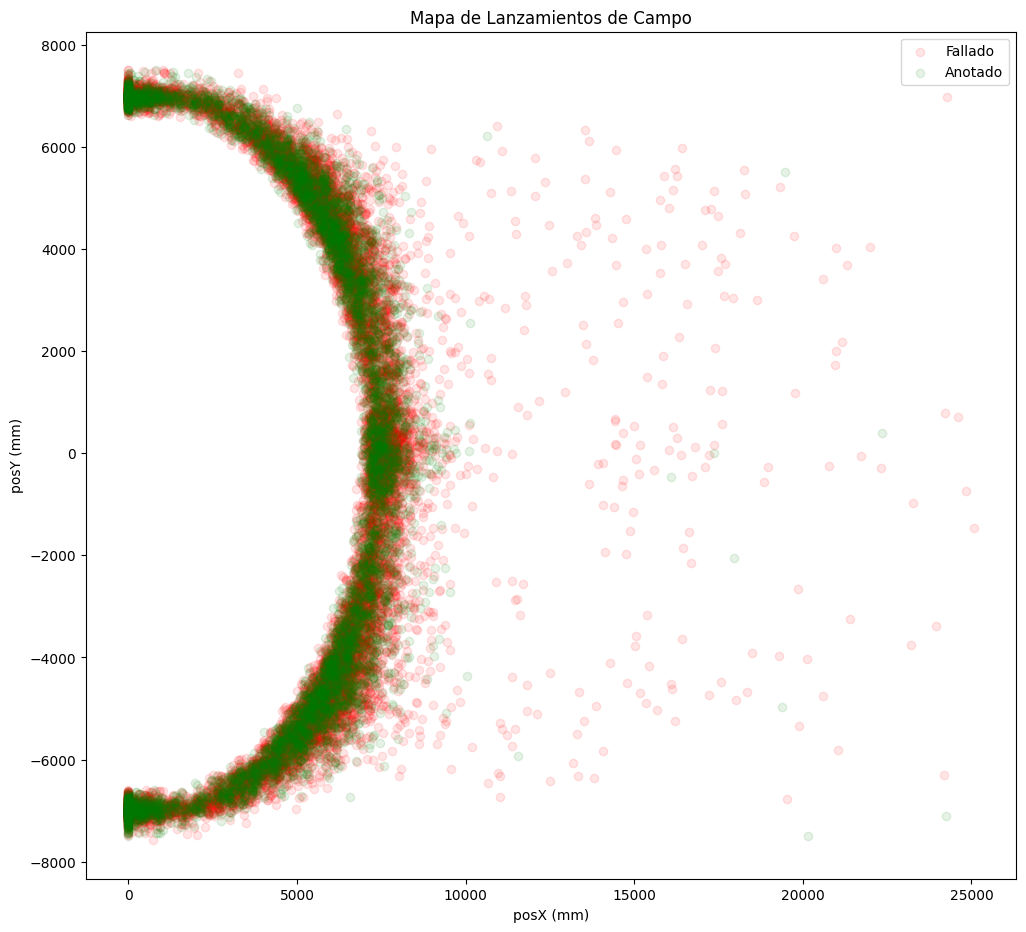

In [ ]:
# Visualizacion de los lanzamientos

import matplotlib.pyplot as plt
import seaborn as sns

# Separamos los tiros anotados de los fallados
tiros_anotados = df_lanzamientos[df_lanzamientos['made_shot'] == 1]
tiros_fallados = df_lanzamientos[df_lanzamientos['made_shot'] == 0]

# Creamos el gráfico
plt.figure(figsize=(12, 11))
plt.scatter(tiros_fallados['posX'], tiros_fallados['posY'], alpha=0.1, c='red', label='Fallado')
plt.scatter(tiros_anotados['posX'], tiros_anotados['posY'], alpha=0.1, c='green', label='Anotado')
plt.title('Mapa de Lanzamientos de Campo')
plt.xlabel('posX (mm)')
plt.ylabel('posY (mm)')
plt.legend()
plt.show()

In [ ]:
# Porcentaje de aciertos para Lanzamientos de 2 y Lanzamientos de 3

df_lanzamientos.groupby('valor_lanzamiento')['made_shot'].mean()

,made_shot
valor_lanzamiento,
3,0.354957


<Axes: xlabel='tiempo_reloj_posesion', ylabel='made_shot'>

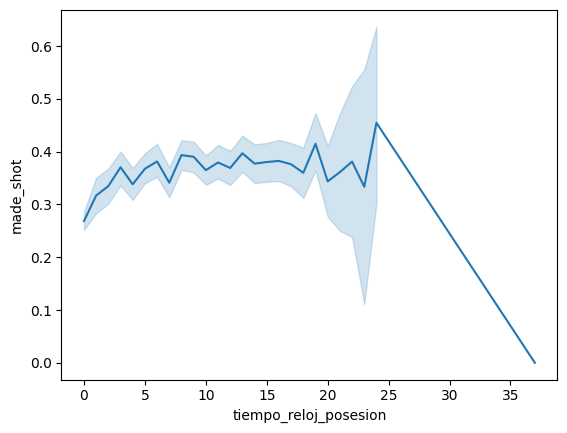

In [ ]:
# Visualización del porcentaje de acierto en función del reloj de posesión

sns.lineplot(x='tiempo_reloj_posesion', y='made_shot', data=df_lanzamientos)

/tmp/ipython-input-179872004.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acierto_por_diferencia = df_lanzamientos.groupby('rango_diferencia')['made_shot'].mean().reset_index()
/tmp/ipython-input-179872004.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rango_diferencia', y='made_shot', data=acierto_por_diferencia, palette='coolwarm')


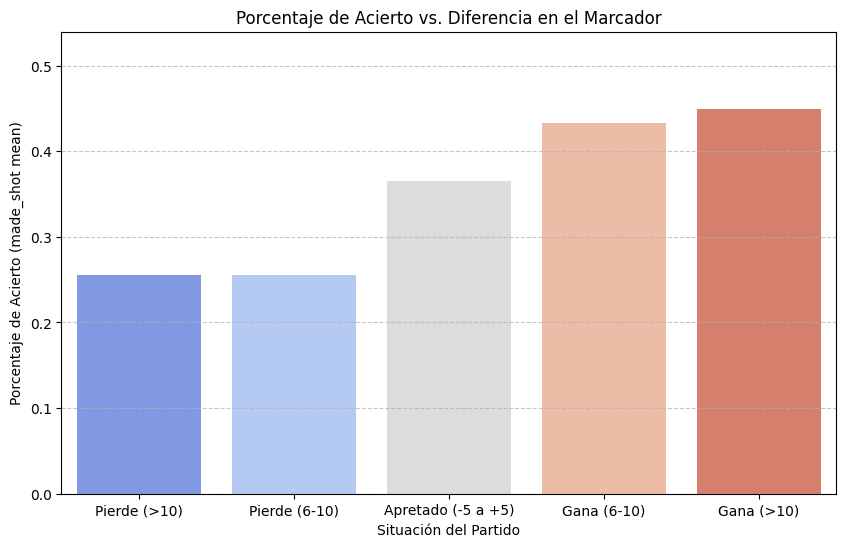

In [ ]:
# ¿Cómo afecta la diferencia en el marcador?

# 1. Creamos los rangos para la diferencia en el marcador.
#    Puedes ajustar los límites de los rangos según lo que consideres 'apretado' o 'abultado'.
bins = [-float('inf'), -10, -5, 5, 10, float('inf')]
labels = ['Pierde (>10)', 'Pierde (6-10)', 'Apretado (-5 a +5)', 'Gana (6-10)', 'Gana (>10)']
df_lanzamientos['rango_diferencia'] = pd.cut(df_lanzamientos['diferencia'], bins=bins, labels=labels)

# 2. Calculamos el porcentaje de acierto para cada rango.
acierto_por_diferencia = df_lanzamientos.groupby('rango_diferencia')['made_shot'].mean().reset_index()

# 3. Creamos el gráfico de barras.
plt.figure(figsize=(10, 6))
sns.barplot(x='rango_diferencia', y='made_shot', data=acierto_por_diferencia, palette='coolwarm')

plt.title('Porcentaje de Acierto vs. Diferencia en el Marcador')
plt.xlabel('Situación del Partido')
plt.ylabel('Porcentaje de Acierto (made_shot mean)')
plt.ylim(0, max(acierto_por_diferencia['made_shot']) * 1.2) # Ajusta el límite del eje Y
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipython-input-2538380962.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='period', y='made_shot', data=acierto_por_cuarto, palette='viridis')


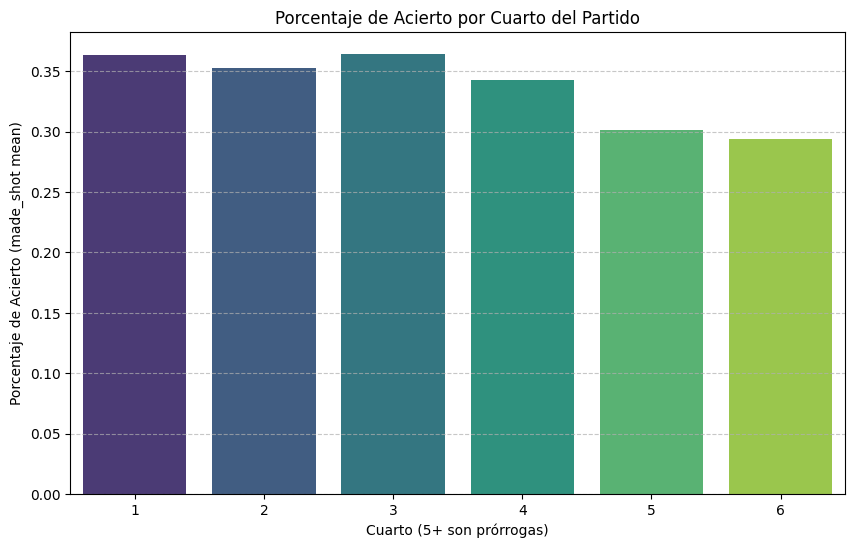

In [ ]:
# Influencia del cuarto en que está el partido

# 1. Calculamos el porcentaje de acierto para cada cuarto.
acierto_por_cuarto = df_lanzamientos.groupby('period')['made_shot'].mean().reset_index()

# 2. Creamos el gráfico de barras.
plt.figure(figsize=(10, 6))
sns.barplot(x='period', y='made_shot', data=acierto_por_cuarto, palette='viridis')

plt.title('Porcentaje de Acierto por Cuarto del Partido')
plt.xlabel('Cuarto (5+ son prórrogas)')
plt.ylabel('Porcentaje de Acierto (made_shot mean)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Ingeniería de características

import numpy as np

# 1. Distancia a la canasta (en metros)
# Usamos el teorema de Pitágoras y convertimos de mm a m
df_lanzamientos['distancia_tiro'] = np.sqrt(df_lanzamientos['posX']**2 + df_lanzamientos['posY']**2) / 1000

# 2. Ángulo del lanzamiento (en grados)
# Usamos arctan2 para obtener el ángulo y lo convertimos a grados
df_lanzamientos['angulo_tiro'] = np.degrees(np.arctan2(df_lanzamientos['posY'], df_lanzamientos['posX']))

# 3. Características de contexto
df_lanzamientos['es_ultimo_minuto'] = (df_lanzamientos['period_seconds_remaining'] < 60).astype(int)
df_lanzamientos['es_posesion_final'] = (df_lanzamientos['tiempo_reloj_posesion'] < 4).astype(int)
df_lanzamientos['es_partido_ajustado'] = (df_lanzamientos['diferencia'].abs() <= 5).astype(int)

# Verificamos las nuevas columnas
print("Nuevas columnas creadas. Mostrando una muestra:")
print(df_lanzamientos[['distancia_tiro', 'angulo_tiro', 'es_ultimo_minuto', 'es_posesion_final', 'es_partido_ajustado']].head())

Nuevas columnas creadas. Mostrando una muestra:
   distancia_tiro  angulo_tiro  es_ultimo_minuto  es_posesion_final  \
2        7.141740    17.209490                 0                  1   
3        7.364406    -6.839375                 0                  0   
5        7.294004   -30.573079                 0                  0   
6        7.475630    44.707345                 0                  0   
8        7.264582    49.281506                 0                  1   

   es_partido_ajustado  
2                    1  
3                    1  
5                    1  
6                    1  
8                    1  


In [ ]:
# Empezamos con el modelo para LANZAMIENTOS DE 3

In [ ]:
df_3ptos = df_lanzamientos[df_lanzamientos['valor_lanzamiento'] == 3].copy()

In [ ]:
# Separar variable Objetivo (y) y Características (X)

# Seleccionamos las columnas que usaremos como predictores
features = [
    'local', 'period', 'posX', 'posY', 'period_seconds_remaining',
    'tiempo_reloj_posesion', 'diferencia', 'distancia_tiro', 'angulo_tiro',
    'es_ultimo_minuto', 'es_posesion_final', 'es_partido_ajustado'
]

X = df_3ptos[features]
y = df_3ptos['made_shot']

In [ ]:
# División en Entrenamiento - Test + Escalado y tratamiento de variables categóricas

# Pipeline de preprocesamiento completo.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Definir qué columnas son numéricas y cuáles categóricas
numeric_features = [
    'posX', 'posY', 'period_seconds_remaining', 'tiempo_reloj_posesion',
    'diferencia', 'distancia_tiro', 'angulo_tiro', 'es_ultimo_minuto',
    'es_posesion_final', 'es_partido_ajustado'
]

categorical_features = ['period', 'local']

# Crear el pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Dividir los datos ANTES de cualquier preprocesamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Crear el pipeline completo para entrenar modelos y crear las métricas de evaluación

# Ejemplo de la estructura del bucle de entrenamiento y evaluación

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss, accuracy_score

# Creamos el pipeline completo (preprocesador + modelo)
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42))])

# Entrenamos
pipeline_lr.fit(X_train, y_train)

# Predecimos probabilidades
y_prob = pipeline_lr.predict_proba(X_test)[:, 1]
y_pred = pipeline_lr.predict(X_test)

# Evaluamos
auc = roc_auc_score(y_test, y_prob)
logloss = log_loss(y_test, y_prob)
brier = brier_score_loss(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
puntos_reales = y_test.sum() * 2
puntos_esperados = y_prob.sum() * 2

# Guardamos los resultados
results_df = pd.DataFrame({
    'Modelo': ['Regresión Logística'],
    'AUC': [auc],
    'Log-Loss': [logloss],
    'Brier Score': [brier],
    'Accuracy': [accuracy],
    'Puntos Reales': [puntos_reales],
    'Puntos Esperados': [puntos_esperados]
})

print(results_df)

                Modelo       AUC  Log-Loss  Brier Score  Accuracy  \
0  Regresión Logística  0.621672  0.629062     0.219426  0.649699   

   Puntos Reales  Puntos Esperados  
0           2594       2590.617624  


In [ ]:
# Creación y Entrenamiento del Pipeline XGBoost
import xgboost as xgb

# Usamos los parámetros por defecto de XGBoost para esta primera prueba
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', xgb_model)])

print("Entrenando el modelo XGBoost...")
pipeline_xgb.fit(X_train, y_train)
print("Entrenamiento completado.")

# Evaluación del Modelo
y_prob_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = pipeline_xgb.predict(X_test)

# Calcular métricas
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
logloss_xgb = log_loss(y_test, y_prob_xgb)
brier_xgb = brier_score_loss(y_test, y_prob_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
puntos_reales_xgb = y_test.sum() * 2
puntos_esperados_xgb = y_prob_xgb.sum() * 2

# Presentación de Resultados
results_xgb = pd.DataFrame({
    'Modelo': ['XGBoost (Default)'],
    'AUC': [auc_xgb],
    'Log-Loss': [logloss_xgb],
    'Brier Score': [brier_xgb],
    'Accuracy': [accuracy_xgb],
    'Puntos Reales': [puntos_reales_xgb],
    'Puntos Esperados': [puntos_esperados_xgb]
})

print("\n--- Resultados del Modelo XGBoost ---")
print(results_xgb)

Entrenando el modelo XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:26:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Entrenamiento completado.

--- Resultados del Modelo XGBoost ---
              Modelo       AUC  Log-Loss  Brier Score  Accuracy  \
0  XGBoost (Default)  0.601246  0.654127     0.228384  0.639299   

   Puntos Reales  Puntos Esperados  
0           2594        2569.95459  


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Búsqueda de Hiperparámetros con RandomizedSearchCV

# Definimos el pipeline con el clasificador
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Definimos el espacio de búsqueda de hiperparámetros
# NOTA: Usamos 'classifier__' como prefijo para que el pipeline sepa a qué paso aplicar los parámetros
param_dist = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Creamos el objeto de búsqueda
# n_iter: número de combinaciones a probar. A más iteraciones, más tarda pero puede encontrar mejores resultados.
# cv: número de folds para la validación cruzada.
# scoring: la métrica que usaremos para decidir qué combinación es la mejor. AUC es ideal.
# n_jobs=-1: usa todos los núcleos de la CPU para acelerar el proceso.
random_search = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_dist,
    n_iter=50,  # Probar 50 combinaciones
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1 # Muestra información mientras se ejecuta
)

print("Iniciando la búsqueda de hiperparámetros...")
random_search.fit(X_train, y_train)
print("Búsqueda completada.")

# Mostramos los mejores parámetros encontrados
print("\nMejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Evaluación del Modelo Optimizado
best_model = random_search.best_estimator_

y_prob_best = best_model.predict_proba(X_test)[:, 1]
y_pred_best = best_model.predict(X_test)

# Calcular métricas
auc_best = roc_auc_score(y_test, y_prob_best)
logloss_best = log_loss(y_test, y_prob_best)
brier_best = brier_score_loss(y_test, y_prob_best)
accuracy_best = accuracy_score(y_test, y_pred_best)
puntos_reales_best = y_test.sum() * 2
puntos_esperados_best = y_prob_best.sum() * 2

# Presentación de Resultados
results_best = pd.DataFrame({
    'Modelo': ['XGBoost (Optimizado)'],
    'AUC': [auc_best],
    'Log-Loss': [logloss_best],
    'Brier Score': [brier_best],
    'Accuracy': [accuracy_best],
    'Puntos Reales': [puntos_reales_best],
    'Puntos Esperados': [puntos_esperados_best]
})

print("\n--- Resultados del Modelo XGBoost Optimizado ---")
print(results_best)

Iniciando la búsqueda de hiperparámetros...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:29:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Búsqueda completada.

Mejores hiperparámetros encontrados:
{'classifier__subsample': 0.9, 'classifier__n_estimators': 100, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01, 'classifier__colsample_bytree': 0.9}

--- Resultados del Modelo XGBoost Optimizado ---
                 Modelo       AUC  Log-Loss  Brier Score  Accuracy  \
0  XGBoost (Optimizado)  0.644674  0.626166     0.218048  0.651888   

   Puntos Reales  Puntos Esperados  
0           2594       2590.704102  


In [ ]:
# TABLA CON EVALUACIÓN DE LOS MODELOS

# 1. Creamos una lista de diccionarios, donde cada diccionario es una fila de nuestra tabla final.

datos_comparativa = [
    {
        'Modelo': 'Regresión Logística',
        'AUC': auc,
        'Log-Loss': logloss,
        'Brier Score': brier,
        'Accuracy': accuracy,
        'Puntos Reales': puntos_reales,
        'Puntos Esperados': puntos_esperados
    },
    {
        'Modelo': 'XGBoost (Default)',
        'AUC': auc_xgb,
        'Log-Loss': logloss_xgb,
        'Brier Score': brier_xgb,
        'Accuracy': accuracy_xgb,
        'Puntos Reales': puntos_reales_xgb,
        'Puntos Esperados': puntos_esperados_xgb
    },
    {
        'Modelo': 'XGBoost (Optimizado)',
        'AUC': auc_best,
        'Log-Loss': logloss_best,
        'Brier Score': brier_best,
        'Accuracy': accuracy_best,
        'Puntos Reales': puntos_reales_best,
        'Puntos Esperados': puntos_esperados_best
    }
]

# 2. Creamos el DataFrame a partir de la lista de diccionarios
cuadro_comparativo = pd.DataFrame(datos_comparativa)

# 3. Ordenamos la tabla por la métrica AUC para ver fácilmente cuál es el mejor
cuadro_comparativo_sorted = cuadro_comparativo.sort_values(by='AUC', ascending=False)


# --- Mostramos el resultado final ---
print("--- 🔥 Cuadro Comparativo Final de Modelos (Lanzamientos de 2) ---")
print(cuadro_comparativo_sorted)

--- 🔥 Cuadro Comparativo Final de Modelos (Lanzamientos de 2) ---
                 Modelo       AUC  Log-Loss  Brier Score  Accuracy  \
2  XGBoost (Optimizado)  0.644674  0.626166     0.218048  0.651888   
0   Regresión Logística  0.621672  0.629062     0.219426  0.649699   
1     XGBoost (Default)  0.601246  0.654127     0.228384  0.639299   

   Puntos Reales  Puntos Esperados  
2           2594       2590.704102  
0           2594       2590.617624  
1           2594       2569.954590  


In [ ]:
# Probamos también con una RED NEURONAL

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Construcción de la Red Neuronal
model_nn = Sequential([
    # Capa de entrada: el número de neuronas debe coincidir con el número de features preprocesadas
    Dense(32, activation='relu', input_shape=[X_train_processed.shape[1]]),
    Dropout(0.3),  # Dropout para prevenir sobreajuste
    Dense(16, activation='relu'),
    Dropout(0.3),
    # Capa de salida: 1 neurona con activación 'sigmoid' para obtener una probabilidad (0 a 1)
    Dense(1, activation='sigmoid')
])

# Compilamos el modelo
model_nn.compile(
    optimizer='adam',
    loss='binary_crossentropy', # Equivalente a Log-Loss
    metrics=['accuracy', 'AUC']
)

# Definimos un callback para detener el entrenamiento si no mejora
early_stopping = EarlyStopping(
    monitor='val_auc', # Monitorea el AUC en los datos de validación
    patience=10,       # Número de épocas sin mejora antes de parar
    mode='max',        # Queremos maximizar el AUC
    restore_best_weights=True # Se queda con los pesos del mejor modelo
)

# Entrenamiento del Modelo
print("Entrenando la Red Neuronal...")
history = model_nn.fit(
    X_train_processed,
    y_train,
    epochs=100, # Un número alto de épocas, EarlyStopping decidirá cuándo parar
    batch_size=64,
    validation_data=(X_test_processed, y_test),
    callbacks=[early_stopping],
    verbose=1 # Muestra el progreso
)
print("Entrenamiento completado.")

# Evaluación del Modelo
y_prob_nn = model_nn.predict(X_test_processed).flatten() # .flatten() para convertirlo en un array 1D
y_pred_nn = (y_prob_nn > 0.5).astype(int)

auc_nn = roc_auc_score(y_test, y_prob_nn)
logloss_nn = log_loss(y_test, y_prob_nn)
brier_nn = brier_score_loss(y_test, y_prob_nn)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
puntos_reales_nn = y_test.sum() * 2
puntos_esperados_nn = y_prob_nn.sum() * 2

# Presentación de Resultados
results_nn = pd.DataFrame({
    'Modelo': ['Red Neuronal'],
    'AUC': [auc_nn],
    'Log-Loss': [logloss_nn],
    'Brier Score': [brier_nn],
    'Accuracy': [accuracy_nn],
    'Puntos Reales': [puntos_reales_nn],
    'Puntos Esperados': [puntos_esperados_nn]
})

print("\n--- Resultados de la Red Neuronal ---")
print(results_nn)

Entrenando la Red Neuronal...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.5461 - accuracy: 0.6134 - loss: 0.6684 - val_AUC: 0.6013 - val_accuracy: 0.6448 - val_loss: 0.6368
Epoch 2/100
 69/229 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5615 - accuracy: 0.6417 - loss: 0.6464

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.5644 - accuracy: 0.6446 - loss: 0.6455 - val_AUC: 0.6104 - val_accuracy: 0.6448 - val_loss: 0.6344
Epoch 3/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.5776 - accuracy: 0.6460 - loss: 0.6424 - val_AUC: 0.6154 - val_accuracy: 0.6456 - val_loss: 0.6346
Epoch 4/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.5763 - accuracy: 0.6459 - loss: 0.6415 - val_AUC: 0.6180 - val_accuracy: 0.6453 - val_loss: 0.6327
Epoch 5/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.5863 - accuracy: 0.6451 - loss: 0.6402 - val_AUC: 0.6219 - val_accuracy: 0.6450 - val_loss: 0.6317
Epoch 6/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.5907 - accuracy: 0.6423 - loss: 0.6390 - val_AUC: 0.6205 - val_accuracy: 0.6461 - val_loss: 0.6319
Epoch 7/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.5904 - accuracy: 0.6388 - loss: 0.6427 - val_AUC: 0.6249 - val_accuracy: 0.6459 - val_loss: 0.6303
Epoch 8/100
229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3m

In [ ]:
# --- Recopilamos los resultados directamente de las variables de cada modelo ---

# Creamos una lista de diccionarios. Cada diccionario representa un modelo.
datos_comparativa_final = [
    {
        'Modelo': 'Regresión Logística',
        'AUC': auc,
        'Log-Loss': logloss,
        'Brier Score': brier,
        'Accuracy': accuracy,
        'Puntos Reales': puntos_reales,
        'Puntos Esperados': puntos_esperados
    },
    {
        'Modelo': 'XGBoost (Default)',
        'AUC': auc_xgb,
        'Log-Loss': logloss_xgb,
        'Brier Score': brier_xgb,
        'Accuracy': accuracy_xgb,
        'Puntos Reales': puntos_reales_xgb,
        'Puntos Esperados': puntos_esperados_xgb
    },
    {
        'Modelo': 'XGBoost (Optimizado)',
        'AUC': auc_best,
        'Log-Loss': logloss_best,
        'Brier Score': brier_best,
        'Accuracy': accuracy_best,
        'Puntos Reales': puntos_reales_best,
        'Puntos Esperados': puntos_esperados_best
    },
    {
        'Modelo': 'Red Neuronal',
        'AUC': auc_nn,
        'Log-Loss': logloss_nn,
        'Brier Score': brier_nn,
        'Accuracy': accuracy_nn,
        'Puntos Reales': puntos_reales_nn,
        'Puntos Esperados': puntos_esperados_nn
    }
]

# Creamos el DataFrame a partir de la lista
cuadro_comparativo = pd.DataFrame(datos_comparativa_final)

# Ordenamos la tabla por AUC descendente para identificar al ganador
cuadro_comparativo_sorted = cuadro_comparativo.sort_values(by='AUC', ascending=False).reset_index(drop=True)


# --- Mostramos el resultado final ---
print("--- 🔥 Cuadro Comparativo Final de Modelos (Lanzamientos de 2) ---")
print(cuadro_comparativo_sorted)

--- 🔥 Cuadro Comparativo Final de Modelos (Lanzamientos de 2) ---
                 Modelo       AUC  Log-Loss  Brier Score  Accuracy  \
0  XGBoost (Optimizado)  0.644674  0.626166     0.218048  0.651888   
1          Red Neuronal  0.631981  0.622364     0.216460  0.659004   
2   Regresión Logística  0.621672  0.629062     0.219426  0.649699   
3     XGBoost (Default)  0.601246  0.654127     0.228384  0.639299   

   Puntos Reales  Puntos Esperados  
0           2594       2590.704102  
1           2594       2601.364014  
2           2594       2590.617624  
3           2594       2569.954590  


In [ ]:
import joblib

# --- 1. Recopilación de Resultados ---
# (Asegúrate de que todas las variables con los resultados de los modelos existen)
datos_comparativa_final = [
    {'Modelo': 'Regresión Logística', 'AUC': auc, 'Log-Loss': logloss, 'Brier Score': brier, 'Accuracy': accuracy, 'Puntos Reales': puntos_reales, 'Puntos Esperados': puntos_esperados},
    {'Modelo': 'XGBoost (Default)', 'AUC': auc_xgb, 'Log-Loss': logloss_xgb, 'Brier Score': brier_xgb, 'Accuracy': accuracy_xgb, 'Puntos Reales': puntos_reales_xgb, 'Puntos Esperados': puntos_esperados_xgb},
    {'Modelo': 'XGBoost (Optimizado)', 'AUC': auc_best, 'Log-Loss': logloss_best, 'Brier Score': brier_best, 'Accuracy': accuracy_best, 'Puntos Reales': puntos_reales_best, 'Puntos Esperados': puntos_esperados_best},
    {'Modelo': 'Red Neuronal', 'AUC': auc_nn, 'Log-Loss': logloss_nn, 'Brier Score': brier_nn, 'Accuracy': accuracy_nn, 'Puntos Reales': puntos_reales_nn, 'Puntos Esperados': puntos_esperados_nn}
]

# --- 2. Creación y Visualización de la Tabla ---
cuadro_comparativo = pd.DataFrame(datos_comparativa_final)
cuadro_comparativo_sorted = cuadro_comparativo.sort_values(by='AUC', ascending=False).reset_index(drop=True)

print("--- 🔥 Cuadro Comparativo Final de Modelos (Lanzamientos de 3) ---")
print(cuadro_comparativo_sorted)


# --- 3. Guardado Automático del Mejor Modelo ---

# Diccionario que mapea el nombre del modelo (string) al objeto del modelo entrenado
# NOTA: Asegúrate de que los nombres de las variables coincidan con los de tu notebook
mapa_modelos = {
    'Regresión Logística': pipeline_lr, # Suponiendo que el pipeline se llama así
    'XGBoost (Default)': pipeline_xgb,
    'XGBoost (Optimizado)': best_model, # El resultado del RandomizedSearchCV
    'Red Neuronal': model_nn
}

# Obtener el nombre del mejor modelo (el primero de la tabla ordenada)
nombre_mejor_modelo = cuadro_comparativo_sorted.loc[0, 'Modelo']

# Seleccionar el objeto del mejor modelo usando el diccionario
objeto_mejor_modelo = mapa_modelos[nombre_mejor_modelo]

# Guardar el objeto seleccionado
nombre_archivo_ganador = 'mejor_modelo_tiros_3_puntos.joblib'
joblib.dump(objeto_mejor_modelo, nombre_archivo_ganador)

print("\n" + "="*50)
print(f"🏆 Modelo Ganador: '{nombre_mejor_modelo}'")
print(f"✅ Modelo guardado automáticamente en: '{nombre_archivo_ganador}'")
print("="*50)

--- 🔥 Cuadro Comparativo Final de Modelos (Lanzamientos de 3) ---
                 Modelo       AUC  Log-Loss  Brier Score  Accuracy  \
0  XGBoost (Optimizado)  0.644674  0.626166     0.218048  0.651888   
1          Red Neuronal  0.631981  0.622364     0.216460  0.659004   
2   Regresión Logística  0.621672  0.629062     0.219426  0.649699   
3     XGBoost (Default)  0.601246  0.654127     0.228384  0.639299   

   Puntos Reales  Puntos Esperados  
0           2594       2590.704102  
1           2594       2601.364014  
2           2594       2590.617624  
3           2594       2569.954590  

🏆 Modelo Ganador: 'XGBoost (Optimizado)'
✅ Modelo guardado automáticamente en: 'mejor_modelo_tiros_3_puntos.joblib'
